In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fixed_point

In [7]:
save_results = True
experiment_name = 'hyperbolic'
# experiment_name = 'hyperbolic_small_network'

In [8]:
with open(f'results/{experiment_name}/results_{experiment_name}.json', 'r') as json_file:
    results = json.load(json_file)
    N = results['N']
    nruns = results['nruns']
    crange = np.linspace(*results['crange'])
    results = results['results']

In [9]:
crange.shape

(200,)

In [10]:
N

1000

In [11]:
T = []
for result in results:
    T.append(np.mean([
        max(item['t'] for item in run['cascade'])
        for run in result['runs']
    ]))

max_t = max(item['t']
            for result in results
            for run in result['runs']
            for item in run['cascade'])

In [12]:
max_t

18

In [13]:
# for result in results:
#     for i, run in enumerate(result['runs']):
#         tvals = [item['t'] for item in run['cascade']]
#         for t in range(max(tvals), max_t + 1):
#             if result['c'] > 5:
#                 run['cascade'].append({
#                     't': t,
#                     'n_ap': 0,
#                     'gcc_size': N,
#                 })

In [14]:
n_ap = {t: [] for t in range(max_t + 1)}
gcc_size = {t: [] for t in range(max_t + 1)}

for result in results:

    n_ap_loc = {t: 0 for t in range(max_t + 1)}
    gcc_size_loc = {t: 0 for t in range(max_t + 1)}
    num_gcc_t = {t: 0 for t in range(max_t + 1)}

    for run in result['runs']:
        for item in run['cascade']:

            n_ap_loc[item['t']] += item['n_ap']
            gcc_size_loc[item['t']] += item['gcc_size']
            num_gcc_t[item['t']] += 1

    for t in range(max_t + 1):

        n_ap[t].append(n_ap_loc[t] / nruns / N)
        gcc_size[t].append(gcc_size_loc[t] / num_gcc_t[t] / N
                           if num_gcc_t[t]
                           else gcc_size[t - 1][-1])

In [15]:
gcc_inf = []
for i, t in enumerate(np.rint(T)):
    gcc_inf.append(gcc_size[t][i])

In [16]:
lw, ms = 1, 3
max_t_for_plots = min(10, max_t)

In [17]:
def G(x, c):
    return np.exp(-c * (1. - x))

In [18]:
crange_ana = np.linspace(0, 8, num=100)
alpha0 = .1 * np.ones_like(crange_ana)
alpha = fixed_point(G, alpha0, args=(crange_ana,))

n_ap_ana = 1 - G(1 - alpha, crange_ana) - crange_ana * alpha * G(np.zeros_like(crange_ana), crange_ana)

In [19]:
plt.rc('text', usetex=True)
plt.rc('font', size=36, **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['savefig.bbox'] = 'tight'

In [20]:
fontsize = 36
labelsize = 30
legendsize = 18
crange_plot = crange[:len(n_ap[0])]
x_crit = crange_plot[np.argmax(T)]
x_crit

6.276130653266332

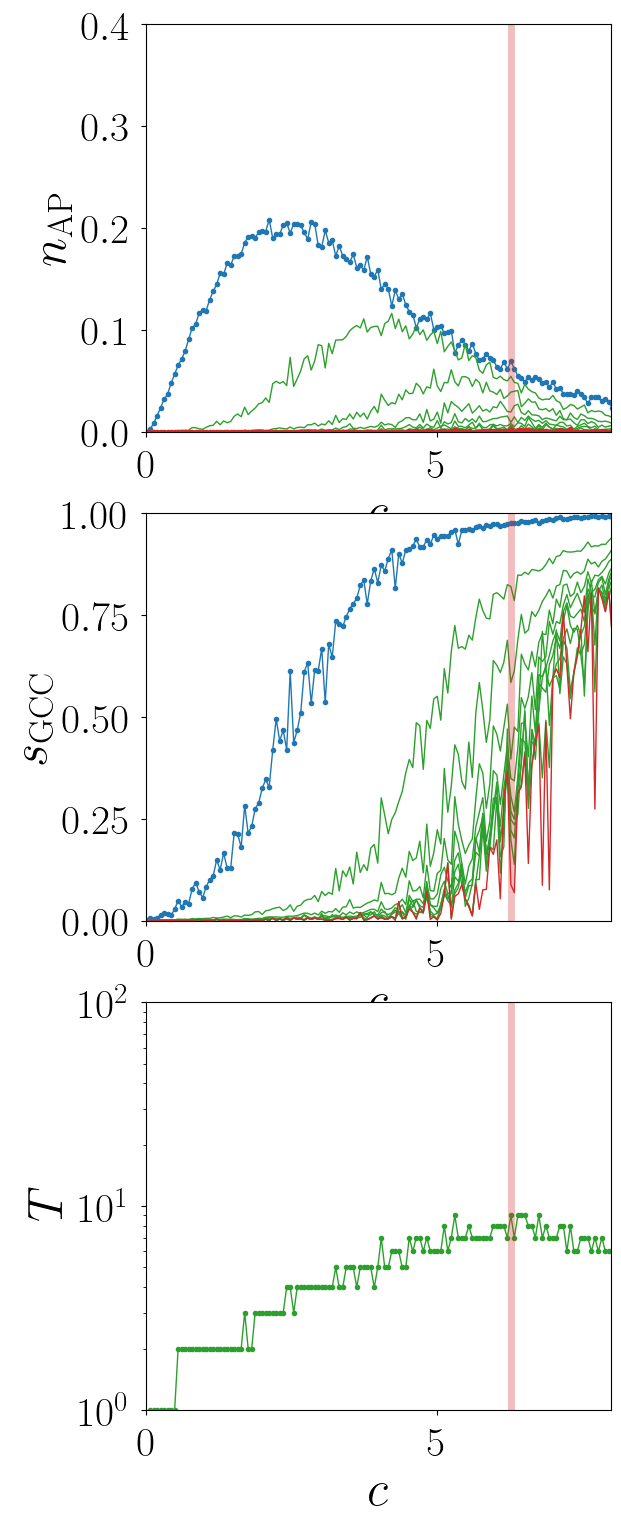

In [21]:
plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 18))

plt.subplot(311)
plt.plot(crange_plot, n_ap[0], 'o-', lw=lw, ms=ms, color='tab:blue', label='$t = 0$')
for t in range(1, max_t_for_plots):
    plt.plot(crange_plot, n_ap[t], '-', lw=lw, ms=ms, color='tab:green')
plt.plot(crange_plot, n_ap[max_t_for_plots], 'o-', lw=lw, ms=ms, color='tab:red', label=f'$t = {max_t_for_plots}$')
# plt.plot(crange_ana, n_ap_ana, '-', lw=1.5, color='tab:orange', label='$\mathrm{theory}$')
plt.axvline(x=x_crit, linewidth=5, alpha=.3, c='tab:red', label='$\mathrm{Phase\ boundary}$')
plt.xlim(0, 8)
plt.ylim(0, .4)
plt.xlabel('$c$', fontdict={'size': fontsize})
plt.ylabel('$n_{\mathrm{AP}}$', fontdict={'size': fontsize})
plt.tick_params(labelbottom=True, axis='both', which='major', labelsize=labelsize)
# plt.legend(fontsize=legendsize)

plt.subplot(312)
plt.plot(crange_plot, gcc_size[0], 'o-', lw=lw, ms=ms, color='tab:blue', label='$t = 0$')
# for t in range(1, max_t_for_plots + 1):
for t in range(1, max_t_for_plots):
    plt.plot(crange_plot, gcc_size[t], '-', lw=lw, ms=ms, color='tab:green')
# plt.plot(crange, gcc_inf, 'o-', lw=lw, ms=ms, color='tab:red', label='$t = \infty$')
plt.plot(crange_plot, gcc_size[max_t_for_plots], '-', lw=lw, ms=ms, color='tab:red', label=f'$t = {max_t_for_plots}$')
plt.axvline(x=x_crit, linewidth=5, alpha=.3, c='tab:red')
plt.xlim(0, 8)
plt.ylim(0, 1)
plt.xlabel('$c$', fontdict={'size': fontsize})
plt.ylabel('$s_{\mathrm{GCC}}$', fontdict={'size': fontsize})
plt.tick_params(labelbottom=True, axis='both', which='major', labelsize=labelsize)
# plt.legend(fontsize=legendsize)

plt.subplot(313)
plt.semilogy(crange_plot, np.rint(T), 'o-', ms=ms, lw=lw, color='tab:green', label='$t = \infty$')
plt.axvline(x=x_crit, linewidth=5, alpha=.3, c='tab:red')
plt.xlim(0, 8)
plt.ylim(1, 100)
plt.xlabel('$c$', fontdict={'size': fontsize})
plt.ylabel('$T$', fontdict={'size': fontsize})
plt.tick_params(axis='both', which='major', labelsize=labelsize)
# plt.legend(fontsize=legendsize)

if save_results:
    plt.savefig(f'results/{experiment_name}/{experiment_name}_mono.pdf')
    plt.savefig(f'results/{experiment_name}/{experiment_name}_mono.png')